In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from untitled import SM_World, plot_SM, plot_raster, make_dataset_first_gm, make_input_and_plot_sdist
from spikeship import spikeship
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import MDS, SpectralEmbedding, TSNE, Isomap

/gs/home/grimaldiav/.conda/envs_ppc/ppc-spikeship/lib/python3.10/site-packages/numba/core/decorators.py:282: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/mnt/pns/home/grimaldiav/Documents/SpikeShip/spikeship/spikeship.py:254: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(int32(int32, int32))


In [23]:
def plot_embedding(embedding, labels, title, colors=['r','g','b']):
    fig, ax = plt.subplots(figsize=(10,5))
    for l in np.unique(labels[:,-1]):
        indices = labels[:,-1]==l
        if l<np.unique(labels[:,-1])[-1]:
            ax.scatter(embedding[indices,1], embedding[indices,0], facecolors=colors[int(l)])
        else:
            ax.scatter(embedding[indices,1], embedding[indices,0], facecolors=labels[indices,:3])
    ax.set_title(title);

def plot_3d_embedding(embedding, labels, title, colors=['r','g','b'], view_init=[0,90]):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection='3d')
    for l in np.unique(labels[:,-1]):
        indices = labels[:,-1]==l
        if l<np.unique(labels[:,-1])[-1]:
            ax.scatter(embedding[indices,0], embedding[indices,1], embedding[indices,2], facecolors=colors[int(l)])
        else:
            ax.scatter(embedding[indices,0], embedding[indices,1], embedding[indices,2], facecolors=labels[indices,:3])
    ax.set_title(title);
    ax.view_init(view_init[0], view_init[1])

In [4]:
class world_params:
    N_pre = 100 # number of neurons in the RP
    N_delays = 51 # number of timesteps in the SM (must be an odd number for convolutions)
    N_kernels = 3 # number of SM used for RP generation

    p_input = .05 # global probability of having a spike in the timebins of the RP as input
    sm_ratio = .5 # probability of a spike as input to belong to the SM
    p_spontaneous =  p_input*(1-sm_ratio)
    p_spike_in_motif = p_input*sm_ratio # probability of having a spike in the timebins of the SM

    avg_N_spikes = p_spike_in_motif*N_delays*N_pre
    std_N_spikes = 1

    N_timesteps =  N_delays # number of timesteps in the RP

    avg_precision = 2 # average precision for the spikes in the SM (inverse of variance of the gaussian distribution defined for 1 spike)
    std_precision = 1 # variance for the precision

    seed = 4815162342 # seed

## Model with 3 motifs and a combination of the 3

The mixture of the 3 kernels is given with a superposition of the kernels with coefficients between 0 and 1. They can be normalized to sum to 1 or not.

In [5]:
N_trials = 10
add_coef = torch.Tensor([.1,.7, .2])

In [6]:
opt = world_params()
world = SM_World(opt, add_coef = add_coef)
input_rp, labels = world.draw_input_one_sm(N_trials = N_trials)

/mnt/pns/home/grimaldiav/Documents/sms/generative_model/untitled.py:32: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /croot/pytorch_1681837271882/work/aten/src/ATen/native/TensorShape.cpp:3281.)
  self.kernels[-1, :, :] = torch.matmul(self.kernels.T,add_coef).T


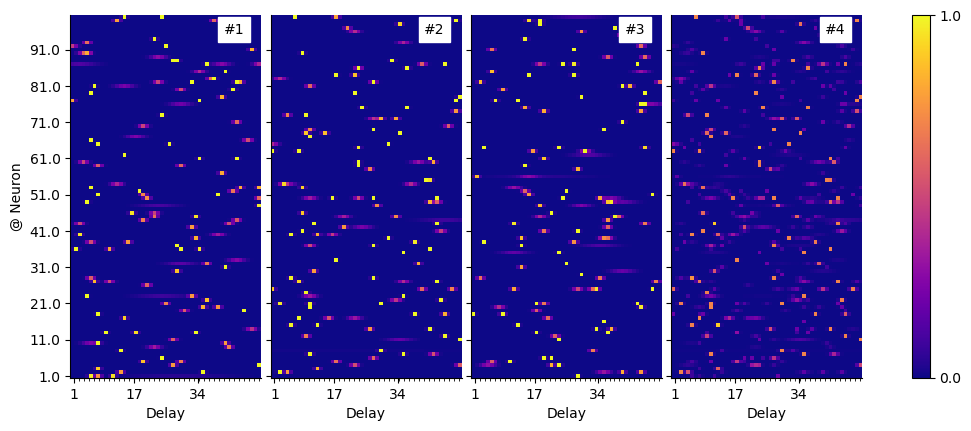

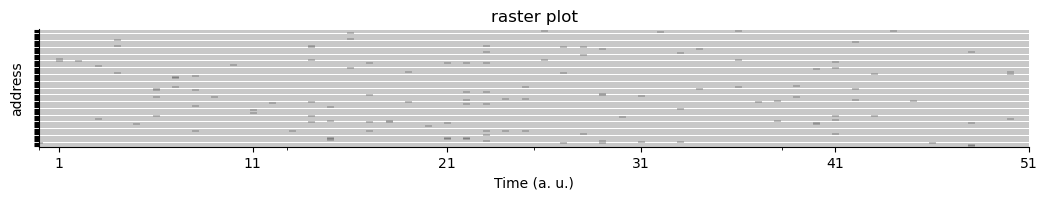

In [7]:
plot_SM(world.kernels, N_show = world.kernels.shape[0], figsize = (12, 5));
plot_raster(input_rp, colored=False);

### Format the ouput for SpikeShip

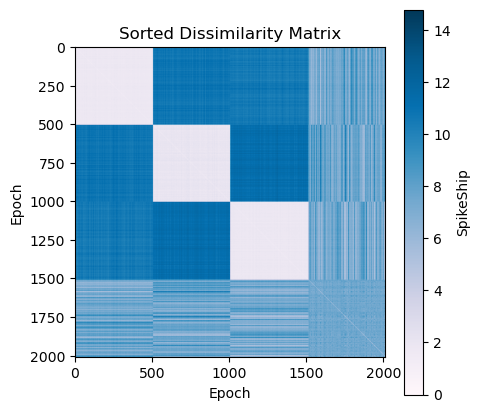

In [8]:
N_trials = 10
N_coef_changes = 200
normalize_coef = True
input_rp, labels, S_dist = make_input_and_plot_sdist(world, N_trials=N_trials, N_coef_changes=N_coef_changes, normalize_coef=normalize_coef)

## Manifold learning
### Laplacian eigenmaps

**From sklearn :** Spectral Embedding is an approach to calculating a non-linear embedding. Scikit-learn implements Laplacian Eigenmaps, which finds a low dimensional representation of the data using a spectral decomposition of the graph Laplacian. The graph generated can be considered as a discrete approximation of the low dimensional manifold in the high dimensional space. Minimization of a cost function based on the graph ensures that points close to each other on the manifold are mapped close to each other in the low dimensional space, preserving local distances. Spectral embedding can be performed with the function spectral_embedding or its object-oriented counterpart SpectralEmbedding.

In [15]:
number_of_components = len(world.add_coef)-1
colors = ['r', 'g', 'b']
print(f'expected number of components : {number_of_components}')

expected number of components : 3


Because we normalize the sum of mixture coefficients to be equal to 1, the problem can be solved with 2 components and we get a better visualization. 

In [16]:
%%time
s_embedding = SpectralEmbedding(n_components=number_of_components, affinity='precomputed', n_neighbors=None)s_embedding = SpectralEmbedding(n_components=number_of_components, affinity='precomputed', n_neighbors=None)s_embedding = SpectralEmbedding(n_components=number_of_components, affinity='precomputed', n_neighbors=None).fit_transform(S_dist)# metric=True, normalized_stress='auto')

CPU times: user 1min 43s, sys: 7.76 ms, total: 1min 43s
Wall time: 932 ms


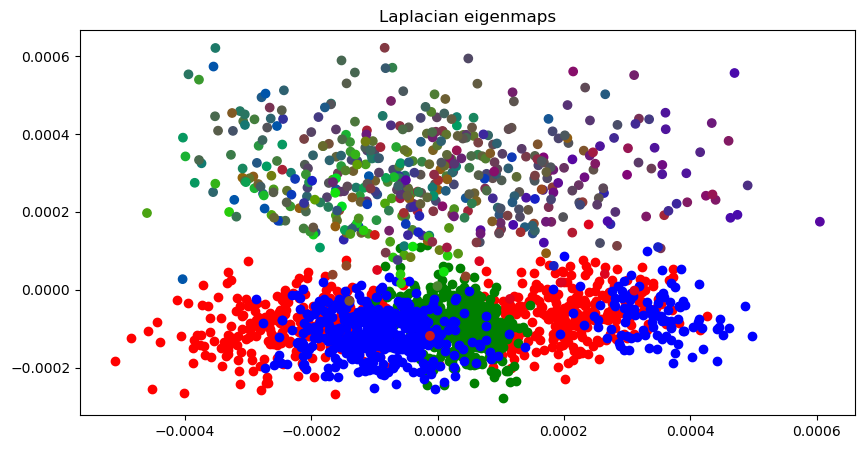

In [21]:
plot_embedding(s_embedding, labels, 'Laplacian eigenmaps')

Not working, tried different values of n_neighbors 

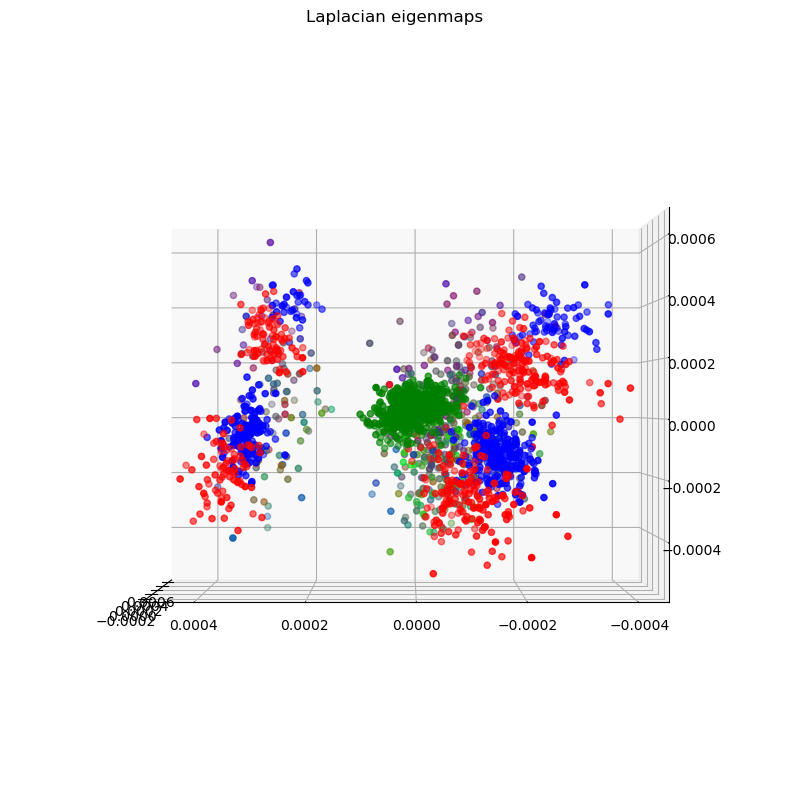

In [27]:
plot_3d_embedding(s_embedding, labels, 'Laplacian eigenmaps', view_init=[0,180])